<h1>Data Mining
<h3>W11 - Class Assignment

Tiffany Christabel Anggriawan - 0706022310041

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

### 2. Data Loading

In [2]:
url = 'https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv'
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (225, 10)

First 5 rows:


,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


### 3. Data Preprocessing

In [3]:
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  225 non-null    object 
 1   Other names              224 non-null    object 
 2   ISO 3166-1 alpha-3 CODE  225 non-null    object 
 3   Population               225 non-null    int64  
 4   Continent                225 non-null    object 
 5   Total Cases              225 non-null    int64  
 6   Total Deaths             225 non-null    int64  
 7   Tot Cases//1M pop        225 non-null    int64  
 8   Tot Deaths/1M pop        225 non-null    int64  
 9   Death percentage         225 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 17.7+ KB

Missing Values:
Country                    0
Other names                1
ISO 3166-1 alpha-3 CODE    0
Population                 0
Continent                  0
Total Ca

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


In [11]:
df_clean = df.copy()

df_clean = df_clean.dropna(subset=['Total Cases', 'Total Deaths', 'Population', 'Continent'])

df_clean = df_clean[df_clean['Total Cases'] > 0]
df_clean = df_clean[df_clean['Population'] > 0]

cases_col = [col for col in df_clean.columns if 'Cases' in col and '1M' in col][0]
deaths_col = [col for col in df_clean.columns if 'Deaths' in col and '1M' in col][0]

df_clean[cases_col] = df_clean[cases_col].fillna(
    (df_clean['Total Cases'] / df_clean['Population']) * 1_000_000
)
df_clean[deaths_col] = df_clean[deaths_col].fillna(
    (df_clean['Total Deaths'] / df_clean['Population']) * 1_000_000
)
df_clean['Death percentage'] = df_clean['Death percentage'].fillna(
    (df_clean['Total Deaths'] / df_clean['Total Cases']) * 100
)

df_clean['Other names'] = df_clean['Other names'].fillna('N/A')

df_clean = df_clean.reset_index(drop=True)

print(f"Original dataset: {df.shape[0]} rows")
print(f"Cleaned dataset: {df_clean.shape[0]} rows")
print(f"Removed: {df.shape[0] - df_clean.shape[0]} rows")
print("\nRemaining missing values:")
print(df_clean.isnull().sum())

Original dataset: 225 rows
Cleaned dataset: 225 rows
Removed: 0 rows

Remaining missing values:
Country                    0
Other names                0
ISO 3166-1 alpha-3 CODE    0
Population                 0
Continent                  0
Total Cases                0
Total Deaths               0
Tot Cases//1M pop          0
Tot Deaths/1M pop          0
Death percentage           0
dtype: int64


### 4. Exploratory Data Analysis (EDA)

In [12]:
continent_stats = df_clean.groupby('Continent').agg({
    'Total Cases': 'sum',
    'Total Deaths': 'sum',
    'Population': 'sum',
    'Country': 'count'
}).rename(columns={'Country': 'Number of Countries'})

continent_stats['Cases per Million'] = (continent_stats['Total Cases'] / continent_stats['Population']) * 1_000_000
continent_stats['Deaths per Million'] = (continent_stats['Total Deaths'] / continent_stats['Population']) * 1_000_000
continent_stats['Death Percentage'] = (continent_stats['Total Deaths'] / continent_stats['Total Cases']) * 100

print("COVID-19 Statistics by Continent:")
continent_stats

COVID-19 Statistics by Continent:


,Total Cases,Total Deaths,Population,Number of Countries,Cases per Million,Deaths per Million,Death Percentage
Continent,,,,,,,
Africa,11764207,252873,1396751613,58,8422.547639,181.043643,2.149512
Asia,140957179,1405003,4668689344,49,30192.023631,300.941634,0.996759
Europe,180332483,1775727,748420351,48,240950.800922,2372.633237,0.984696
Latin America and the Caribbean,67509231,1686828,661325824,48,102081.649544,2550.676140,2.498663
Northern America,85364770,1046062,372846593,5,228954.137178,2805.609652,1.225402
Oceania,5647957,9336,43437948,17,130023.568332,214.927280,0.165299


In [13]:
deaths_col = [col for col in df_clean.columns if 'Deaths' in col and '1M' in col][0]

fig = px.choropleth(df_clean, 
                    locations="ISO 3166-1 alpha-3 CODE",
                    color=deaths_col,
                    hover_name="Country",
                    hover_data={
                        'ISO 3166-1 alpha-3 CODE': False,
                        'Continent': True,
                        'Total Cases': ':,',
                        'Total Deaths': ':,',
                        deaths_col: ':.2f',
                        'Death percentage': ':.2f'
                    },
                    color_continuous_scale="Reds",
                    title="COVID-19 Deaths per Million Population by Country",
                    labels={deaths_col: 'Deaths per 1M'},
                    height=600)

fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth')
)

fig.show()

Visualization 1 Explanation: This world map shows the distribution of COVID-19 deaths per million population across countries, colored by continent. The darker red regions indicate higher death rates per capita, revealing significant geographical disparities in pandemic impact. This visualization helps identify which countries experienced the highest mortality burden relative to their population size.

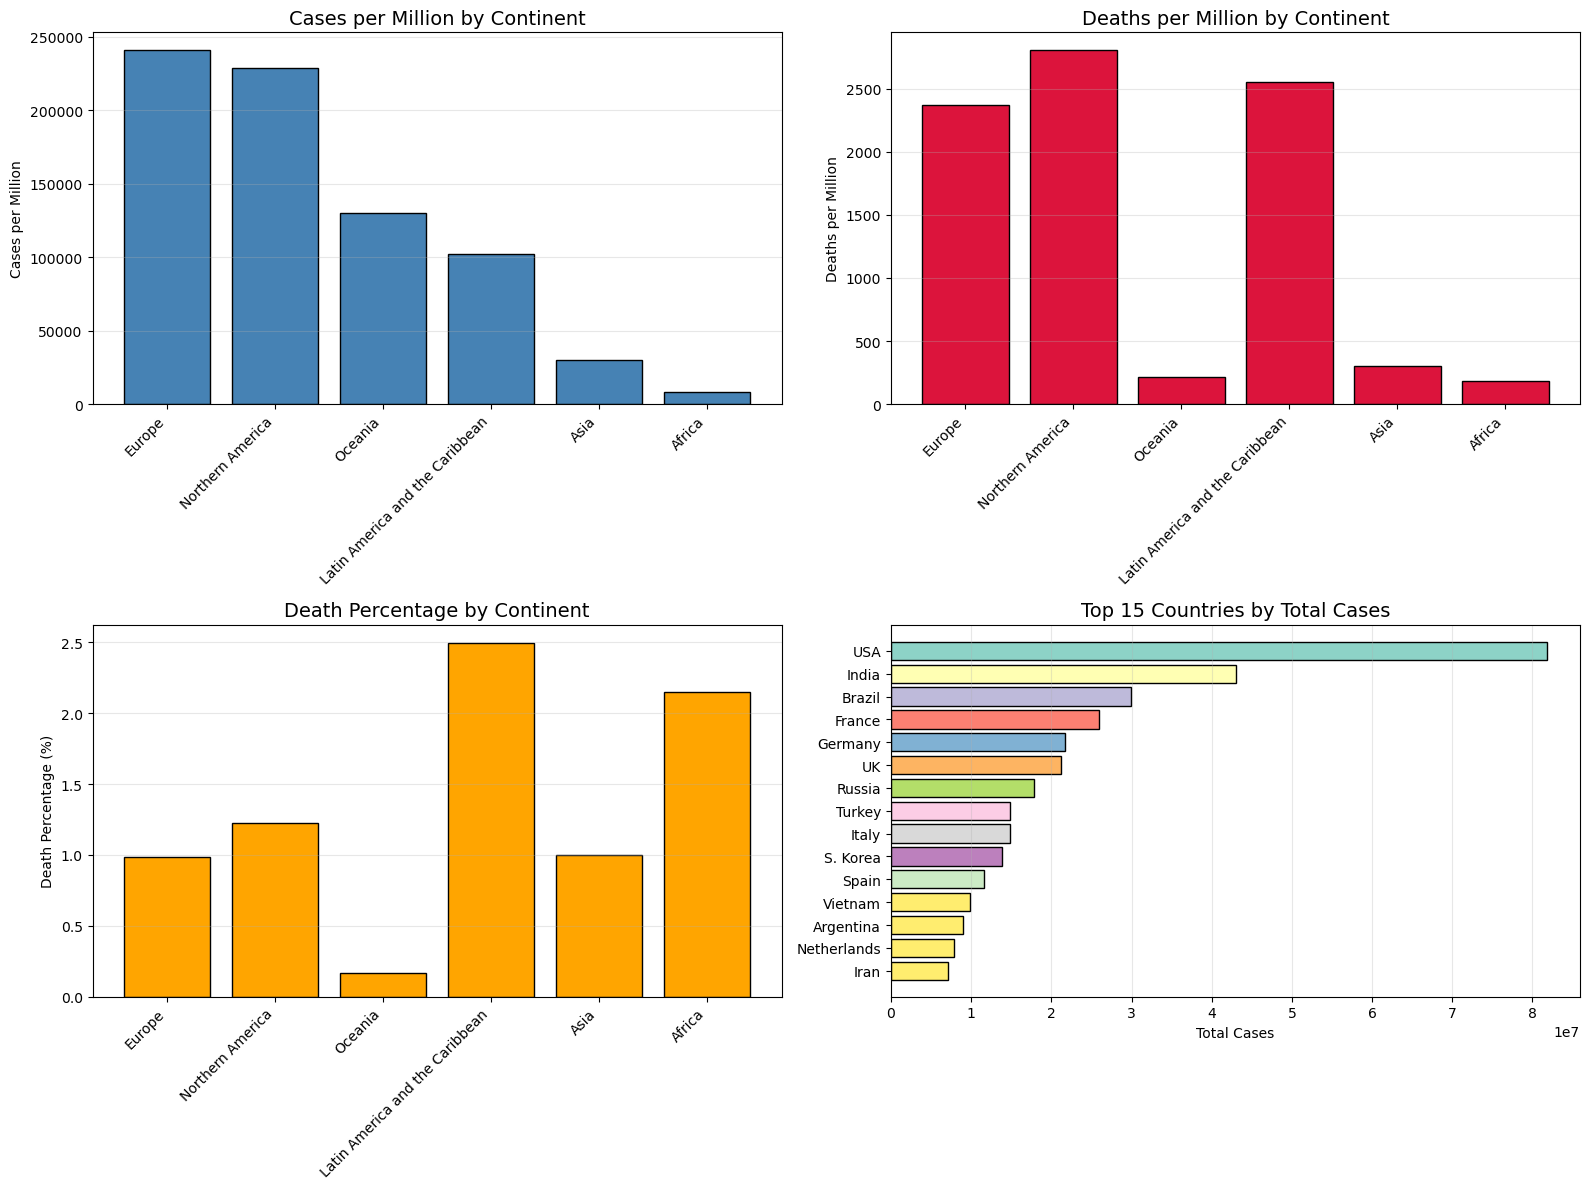

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

continent_order = continent_stats.sort_values('Cases per Million', ascending=False).index

axes[0, 0].bar(range(len(continent_order)), 
               [continent_stats.loc[c, 'Cases per Million'] for c in continent_order],
               color='steelblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(continent_order)))
axes[0, 0].set_xticklabels(continent_order, rotation=45, ha='right')
axes[0, 0].set_title('Cases per Million by Continent', fontsize=14, fontweight='normal')
axes[0, 0].set_ylabel('Cases per Million')
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].bar(range(len(continent_order)), 
               [continent_stats.loc[c, 'Deaths per Million'] for c in continent_order],
               color='crimson', edgecolor='black')
axes[0, 1].set_xticks(range(len(continent_order)))
axes[0, 1].set_xticklabels(continent_order, rotation=45, ha='right')
axes[0, 1].set_title('Deaths per Million by Continent', fontsize=14, fontweight='normal')
axes[0, 1].set_ylabel('Deaths per Million')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(range(len(continent_order)), 
               [continent_stats.loc[c, 'Death Percentage'] for c in continent_order],
               color='orange', edgecolor='black')
axes[1, 0].set_xticks(range(len(continent_order)))
axes[1, 0].set_xticklabels(continent_order, rotation=45, ha='right')
axes[1, 0].set_title('Death Percentage by Continent', fontsize=14, fontweight='normal')
axes[1, 0].set_ylabel('Death Percentage (%)')
axes[1, 0].grid(axis='y', alpha=0.3)

top_countries = df_clean.nlargest(15, 'Total Cases')[['Country', 'Total Cases', 'Continent']]
colors = [plt.cm.Set3(i) for i in range(len(top_countries))]
axes[1, 1].barh(range(len(top_countries)), top_countries['Total Cases'].values, color=colors, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_countries)))
axes[1, 1].set_yticklabels(top_countries['Country'].values)
axes[1, 1].set_title('Top 15 Countries by Total Cases', fontsize=14, fontweight='normal')
axes[1, 1].set_xlabel('Total Cases')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Visualization 2 Explanation: This multi-panel visualization provides comprehensive insights into COVID-19 impact across continents and countries. The continent-level charts reveal that Europe has the highest cases and deaths per million, while Africa shows lower rates possibly due to underreporting or demographic differences. The top 15 countries chart highlights that large populous nations dominate absolute case counts, emphasizing the need for population-adjusted metrics when comparing pandemic severity.

### 5. Encoding and Data Transformation

In [15]:
cases_col = [col for col in df_clean.columns if 'Cases' in col and '1M' in col][0]
deaths_col = [col for col in df_clean.columns if 'Deaths' in col and '1M' in col][0]

clustering_features = [cases_col, deaths_col, 'Death percentage']

df_modeling = df_clean[['Country', 'Continent', 'ISO 3166-1 alpha-3 CODE'] + clustering_features].copy()

df_modeling = df_modeling.dropna(subset=clustering_features)

print("Features selected for clustering:")
print(clustering_features)
print(f"\nDataset shape for modeling: {df_modeling.shape}")
print("\nFeature statistics before scaling:")
df_modeling[clustering_features].describe()

Features selected for clustering:
['Tot\xa0Cases//1M pop', 'Tot\xa0Deaths/1M pop', 'Death percentage']

Dataset shape for modeling: (225, 6)

Feature statistics before scaling:


,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,225.000000,225.000000,225.000000
mean,136900.373333,1096.715556,1.444125
std,145060.340289,1195.715543,1.741728
min,9.000000,0.000000,0.000000
25%,11384.000000,123.000000,0.511291
50%,88987.000000,708.000000,1.036905
75%,223335.000000,1795.000000,1.977017
max,696044.000000,6286.000000,18.151787


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_modeling[clustering_features])

df_scaled = pd.DataFrame(X_scaled, columns=clustering_features, index=df_modeling.index)

print("Scaled features statistics:")
print(df_scaled.describe())
print("\nFirst 5 rows of scaled data:")
print(df_scaled.head())

Scaled features statistics:
       Tot Cases//1M pop  Tot Deaths/1M pop  Death percentage
count       2.250000e+02       2.250000e+02      2.250000e+02
mean        7.894919e-17       4.736952e-17      2.131628e-16
std         1.002230e+00       1.002230e+00      1.002230e+00
min        -9.457898e-01      -9.192494e-01     -8.309821e-01
25%        -8.671993e-01      -8.161528e-01     -5.367737e-01
50%        -3.310361e-01      -3.258152e-01     -2.343236e-01
75%         5.971815e-01       5.852909e-01      3.066382e-01
max         3.863153e+00       4.349575e+00      9.613966e+00

First 5 rows of scaled data:
   Tot Cases//1M pop  Tot Deaths/1M pop  Death percentage
0          -0.915487          -0.759994          1.651243
1          -0.287081           0.099982         -0.097285
2          -0.905275          -0.791845          0.657760
3           2.623123           0.736164         -0.611015
4          -0.926078          -0.873149          0.271204


### 6. Determining Optimal Number of Clusters

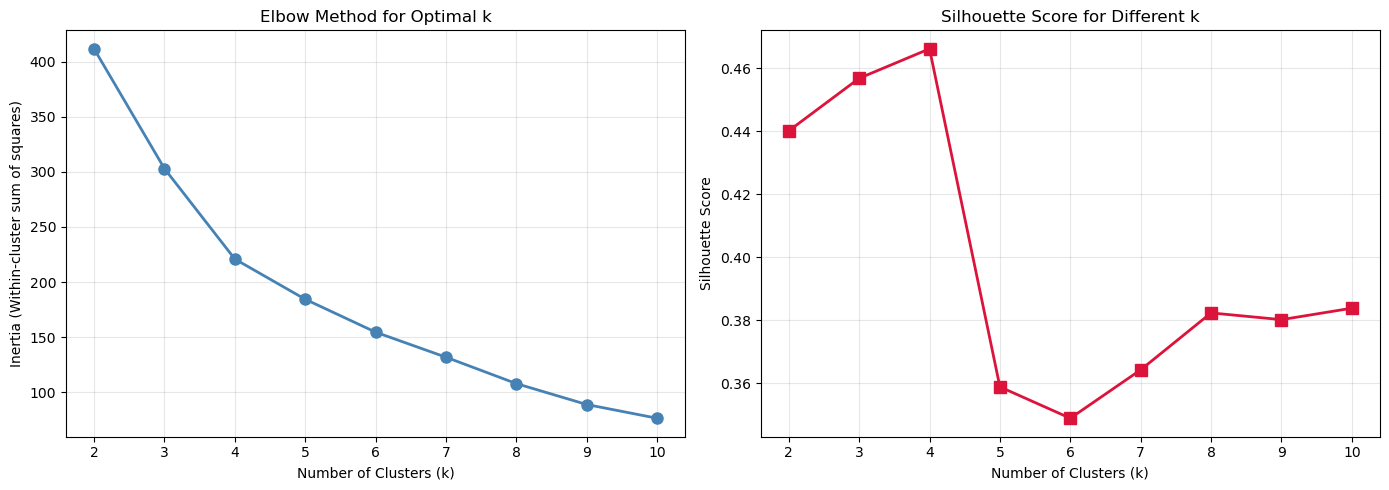


Optimal number of clusters based on Silhouette Score: 4
Best Silhouette Score: 0.4662


In [17]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='crimson')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Different k')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on Silhouette Score: {best_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.4f}")

### 7. KMeans Clustering

In [18]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

df_modeling['KMeans_Cluster'] = kmeans_labels

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print(f"KMeans Clustering with k={best_k}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"\nCluster distribution:")
print(df_modeling['KMeans_Cluster'].value_counts().sort_index())

KMeans Clustering with k=4
Silhouette Score: 0.4662

Cluster distribution:
KMeans_Cluster
0    128
1     62
2     32
3      3
Name: count, dtype: int64


In [19]:
kmeans_summary = df_modeling.groupby('KMeans_Cluster')[clustering_features].agg(['mean', 'median', 'std', 'count'])

print("KMeans Cluster Summary Statistics:")
print(kmeans_summary)

KMeans Cluster Summary Statistics:
               Tot Cases//1M pop                                 \
                            mean    median            std count   
KMeans_Cluster                                                    
0                   42296.664062   19470.0   49918.783170   128   
1                  323964.532258  313133.0  109321.524894    62   
2                  165658.000000  136189.0   93441.200583    32   
3                     584.666667     381.0     693.311137     3   

               Tot Deaths/1M pop                            Death percentage  \
                            mean  median          std count             mean   
KMeans_Cluster                                                                 
0                     378.453125   186.5   430.113625   128         1.416193   
1                    1557.725806  1573.5   805.397696    62         0.526839   
2                    3173.781250  2873.5  1088.038446    32         2.341228   
3              

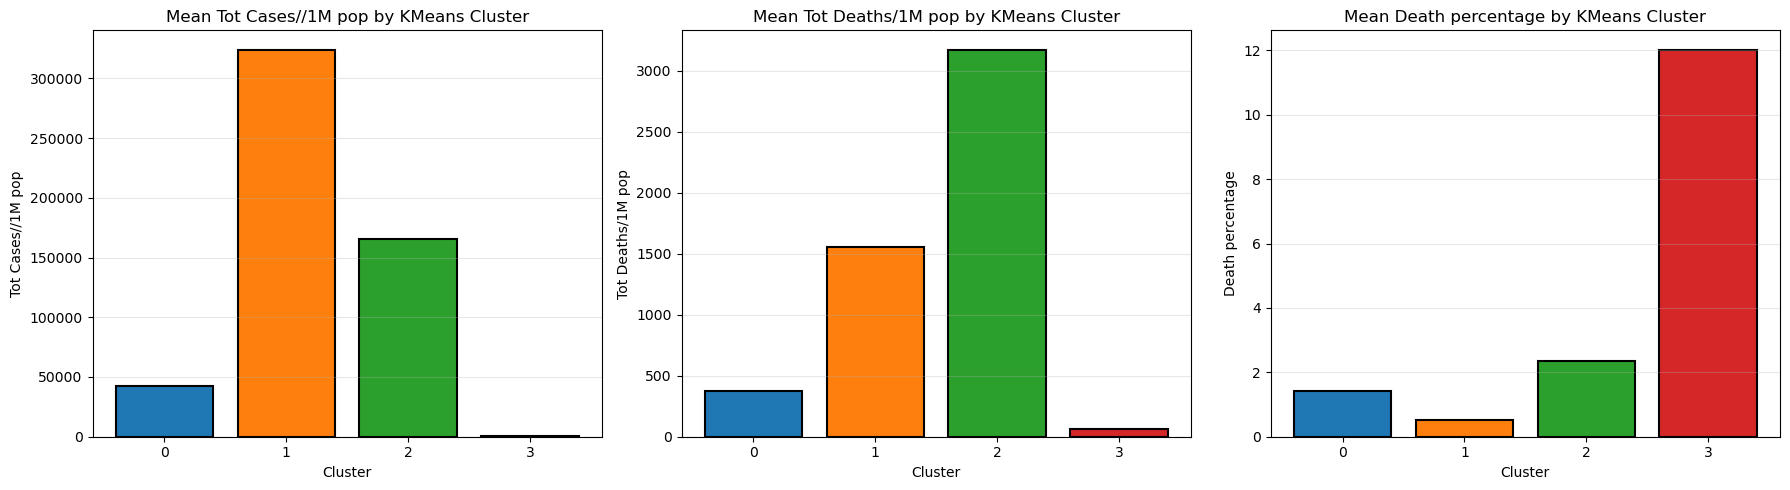

In [20]:
cluster_means = df_modeling.groupby('KMeans_Cluster')[clustering_features].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(clustering_features):
    axes[idx].bar(cluster_means.index, cluster_means[feature], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:best_k],
                  edgecolor='black', linewidth=1.5)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'Mean {feature} by KMeans Cluster')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticks(cluster_means.index)

plt.tight_layout()
plt.show()

In [21]:
fig = px.choropleth(df_modeling, 
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="KMeans_Cluster",
                    hover_name="Country",
                    hover_data={
                        'ISO 3166-1 alpha-3 CODE': False,
                        'Continent': True,
                        cases_col: ':.2f',
                        deaths_col: ':.2f',
                        'Death percentage': ':.2f',
                        'KMeans_Cluster': True
                    },
                    color_continuous_scale="Viridis",
                    title="KMeans Clustering: Countries Grouped by COVID-19 Severity",
                    labels={'KMeans_Cluster': 'Cluster'},
                    height=600)

fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth')
)

fig.show()

### 8. Hierarchical Agglomerative Clustering

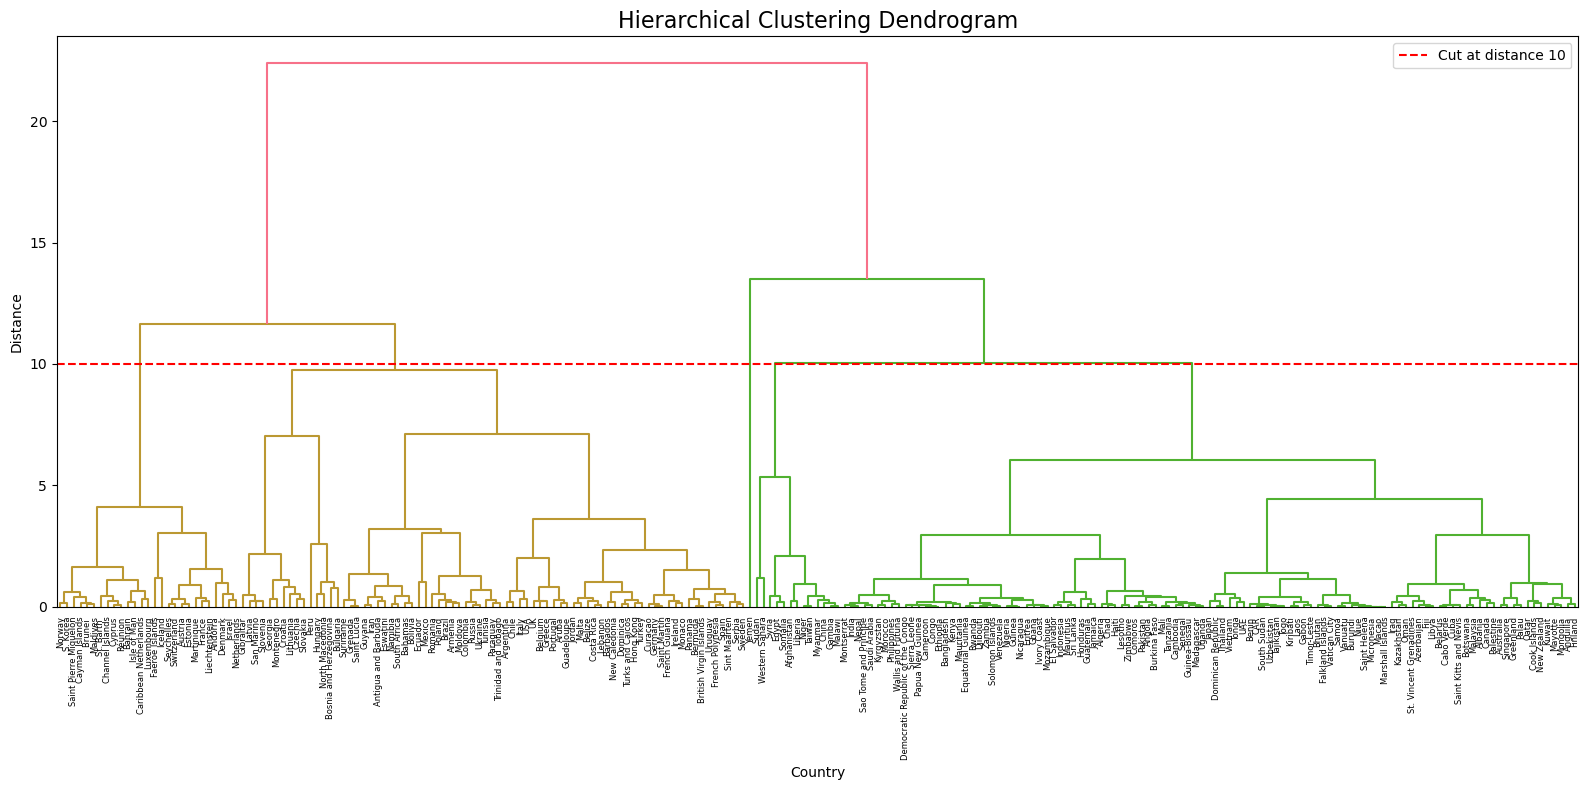

In [22]:
plt.figure(figsize=(16, 8))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, labels=df_modeling['Country'].values, leaf_font_size=6)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Country')
plt.ylabel('Distance')
plt.axhline(y=10, color='r', linestyle='--', label='Cut at distance 10')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

df_modeling['Hierarchical_Cluster'] = hierarchical_labels

hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)

print(f"Hierarchical Clustering with k={best_k}")
print(f"Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"\nCluster distribution:")
print(df_modeling['Hierarchical_Cluster'].value_counts().sort_index())

Hierarchical Clustering with k=4
Silhouette Score: 0.3948

Cluster distribution:
Hierarchical_Cluster
0    122
1     75
2      1
3     27
Name: count, dtype: int64


In [24]:
hierarchical_summary = df_modeling.groupby('Hierarchical_Cluster')[clustering_features].agg(['mean', 'median', 'std', 'count'])

print("Hierarchical Cluster Summary Statistics:")
print(hierarchical_summary)

Hierarchical Cluster Summary Statistics:
                     Tot Cases//1M pop                                 \
                                  mean    median            std count   
Hierarchical_Cluster                                                    
0                         39512.147541   15700.0   51893.838132   122   
1                        204892.760000  179692.0  108312.832514    75   
2                           381.000000     381.0            NaN     1   
3                        393139.407407  390767.0   92878.081362    27   

                     Tot Deaths/1M pop                             \
                                  mean  median          std count   
Hierarchical_Cluster                                                
0                           294.213115   162.0   325.913192   122   
1                          2412.186667  2138.0  1082.011886    75   
2                            69.000000    69.0          NaN     1   
3                          1106.8

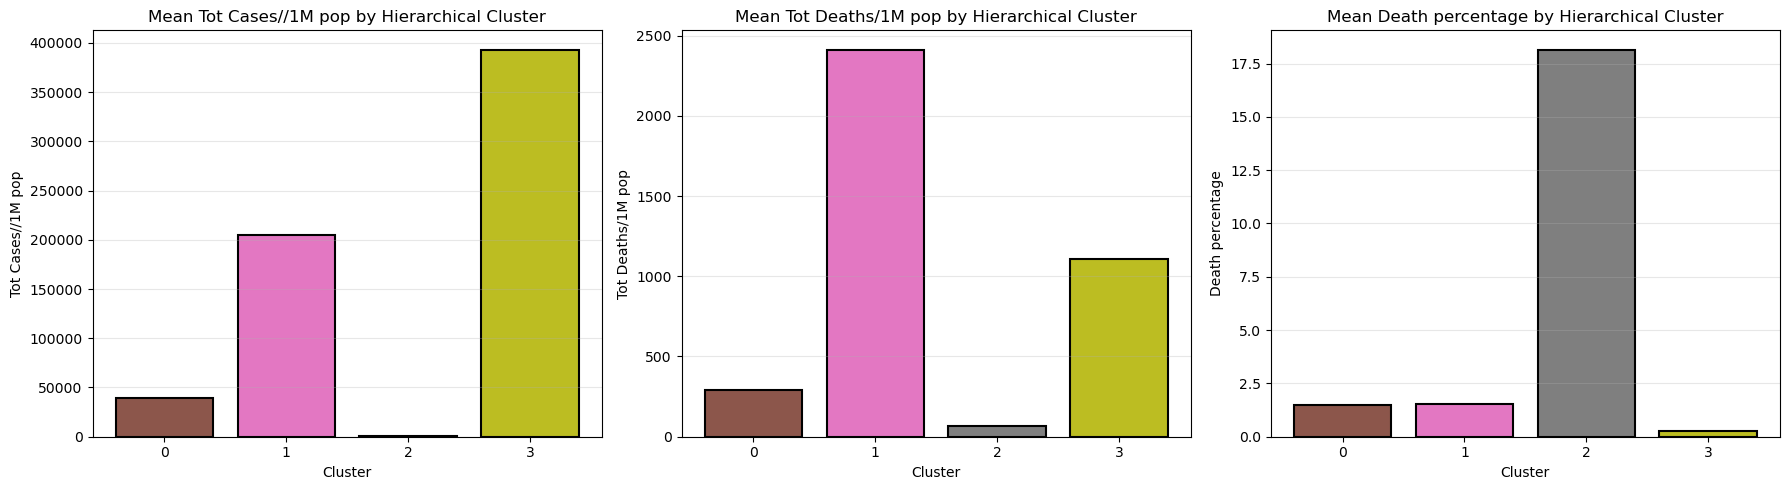

In [25]:
cluster_means_hier = df_modeling.groupby('Hierarchical_Cluster')[clustering_features].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(clustering_features):
    axes[idx].bar(cluster_means_hier.index, cluster_means_hier[feature], 
                  color=['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:best_k],
                  edgecolor='black', linewidth=1.5)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'Mean {feature} by Hierarchical Cluster')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticks(cluster_means_hier.index)

plt.tight_layout()
plt.show()

In [26]:
fig = px.choropleth(df_modeling, 
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="Hierarchical_Cluster",
                    hover_name="Country",
                    hover_data={
                        'ISO 3166-1 alpha-3 CODE': False,
                        'Continent': True,
                        cases_col: ':.2f',
                        deaths_col: ':.2f',
                        'Death percentage': ':.2f',
                        'Hierarchical_Cluster': True
                    },
                    color_continuous_scale="Plasma",
                    title="Hierarchical Clustering: Countries Grouped by COVID-19 Severity",
                    labels={'Hierarchical_Cluster': 'Cluster'},
                    height=600)

fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth')
)

fig.show()

### 9. Model Evaluation and Comparison

In [28]:
comparison_data = {
    'Model': ['KMeans', 'Hierarchical'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette],
    'Number of Clusters': [best_k, best_k]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

if kmeans_silhouette > hierarchical_silhouette:
    best_model = "KMeans"
    score_diff = kmeans_silhouette - hierarchical_silhouette
else:
    best_model = "Hierarchical"
    score_diff = hierarchical_silhouette - kmeans_silhouette

print(f"\nBest Model: {best_model}")
print(f"Score Difference: {score_diff:.4f}")
print("\nExplanation:")
if kmeans_silhouette > hierarchical_silhouette:
    print("KMeans performs better than Hierarchical Clustering based on the Silhouette Score.")
    print("KMeans creates more cohesive and well-separated clusters by iteratively optimizing")
    print("cluster centers, making it more suitable for this dataset where the features")
    print("(cases per million, deaths per million, death percentage) have clear patterns")
    print("that benefit from centroid-based partitioning. The higher silhouette score indicates")
    print("that countries within each cluster are more similar to each other and more distinct")
    print("from countries in other clusters.")
else:
    print("Hierarchical Clustering performs better than KMeans based on the Silhouette Score.")
    print("Hierarchical Clustering captures the nested structure of COVID-19 severity levels")
    print("more effectively by building a hierarchy of clusters. This approach is beneficial")
    print("when the data has a natural hierarchical structure, as it can reveal relationships")
    print("between countries at different levels of granularity. The higher silhouette score")
    print("suggests that the hierarchical approach creates more natural groupings for this dataset.")

Model Comparison:
          Model  Silhouette Score  Number of Clusters
0        KMeans          0.466190                   4
1  Hierarchical          0.394821                   4

Best Model: KMeans
Score Difference: 0.0714

Explanation:
KMeans performs better than Hierarchical Clustering based on the Silhouette Score.
KMeans creates more cohesive and well-separated clusters by iteratively optimizing
cluster centers, making it more suitable for this dataset where the features
(cases per million, deaths per million, death percentage) have clear patterns
that benefit from centroid-based partitioning. The higher silhouette score indicates
that countries within each cluster are more similar to each other and more distinct
from countries in other clusters.


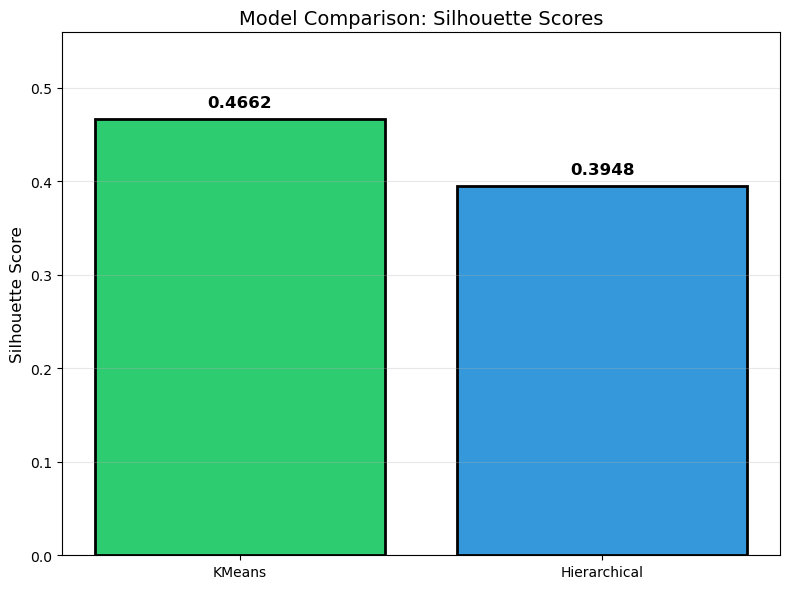

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
models = ['KMeans', 'Hierarchical']
scores = [kmeans_silhouette, hierarchical_silhouette]
colors = ['#2ecc71' if s == max(scores) else '#3498db' for s in scores]

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Model Comparison: Silhouette Scores', fontsize=14)
ax.set_ylim([0, max(scores) * 1.2])
ax.grid(axis='y', alpha=0.3)

for i, (model, score) in enumerate(zip(models, scores)):
    ax.text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 10. Cluster Profiling (Using Best Model)

In [30]:
if kmeans_silhouette > hierarchical_silhouette:
    df_modeling['Best_Cluster'] = df_modeling['KMeans_Cluster']
    selected_model = "KMeans"
else:
    df_modeling['Best_Cluster'] = df_modeling['Hierarchical_Cluster']
    selected_model = "Hierarchical"

print(f"Selected Model for Profiling: {selected_model}")

Selected Model for Profiling: KMeans


In [33]:
for cluster_id in sorted(df_modeling['Best_Cluster'].unique()):
    print(f"\nCluster {cluster_id} Profile:")
    cluster_data = df_modeling[df_modeling['Best_Cluster'] == cluster_id]
    
    print(f"\nNumber of Countries: {len(cluster_data)}")
    print(f"\nKey Statistics:")
    print(f"  - Mean Cases per Million: {cluster_data[cases_col].mean():.2f}")
    print(f"  - Mean Deaths per Million: {cluster_data[deaths_col].mean():.2f}")
    print(f"  - Mean Death Percentage: {cluster_data['Death percentage'].mean():.2f}%")
    
    print(f"\nContinent Distribution:")
    print(cluster_data['Continent'].value_counts())
    
    print(f"\nTop 5 Countries in this Cluster:")
    top_countries = cluster_data.nlargest(5, deaths_col)[['Country', cases_col, deaths_col, 'Death percentage']]
    for idx, row in top_countries.iterrows():
        print(f"  - {row['Country']}: {row[deaths_col]:.2f} deaths/1M, {row['Death percentage']:.2f}% CFR")


Cluster 0 Profile:

Number of Countries: 128

Key Statistics:
  - Mean Cases per Million: 42296.66
  - Mean Deaths per Million: 378.45
  - Mean Death Percentage: 1.42%

Continent Distribution:
Continent
Africa                             53
Asia                               37
Latin America and the Caribbean    19
Oceania                            14
Europe                              4
Northern America                    1
Name: count, dtype: int64

Top 5 Countries in this Cluster:
  - South Africa: 1651.00 deaths/1M, 2.69% CFR
  - Iran: 1634.00 deaths/1M, 1.96% CFR
  - Belize: 1599.00 deaths/1M, 1.15% CFR
  - Guyana: 1546.00 deaths/1M, 1.94% CFR
  - Namibia: 1533.00 deaths/1M, 2.55% CFR

Cluster 1 Profile:

Number of Countries: 62

Key Statistics:
  - Mean Cases per Million: 323964.53
  - Mean Deaths per Million: 1557.73
  - Mean Death Percentage: 0.53%

Continent Distribution:
Continent
Europe                             30
Latin America and the Caribbean    15
Asia             

### 11. Government Policy Recommendations

In [34]:
cluster_stats = df_modeling.groupby('Best_Cluster')[clustering_features].mean().sort_values(deaths_col)

print("Government Policy Recommendations by Cluster:")

for cluster_id in cluster_stats.index:
    cluster_data = df_modeling[df_modeling['Best_Cluster'] == cluster_id]
    avg_cases = cluster_data[cases_col].mean()
    avg_deaths = cluster_data[deaths_col].mean()
    avg_cfr = cluster_data['Death percentage'].mean()
    
    print(f"\nCluster {cluster_id}:")
    print(f"Average Profile: {avg_cases:.0f} cases/1M, {avg_deaths:.0f} deaths/1M, {avg_cfr:.2f}% CFR")
    print(f"Risk Level: ", end="")
    
    if avg_deaths < 500:
        risk = "LOW"
        color = "GREEN"
    elif avg_deaths < 1500:
        risk = "MODERATE"
        color = "YELLOW"
    elif avg_deaths < 3000:
        risk = "HIGH"
        color = "ORANGE"
    else:
        risk = "CRITICAL"
        color = "RED"
    
    print(f"{risk} ({color})")
    print("\nPolicy Recommendations:")
    
    if avg_deaths < 500 and avg_cases < 50000:
        print("  1. Countries in this cluster show extremely low COVID-19 impact, possibly indicating")
        print("     underreporting or limited testing capacity. Governments must increase testing")
        print("     infrastructure and surveillance systems to detect true infection rates.")
        print("  2. Invest in healthcare data collection systems to ensure accurate pandemic monitoring.")
        print("  3. Establish early warning systems for potential future outbreaks.")
        
    elif avg_deaths < 500 and avg_cases >= 50000:
        print("  1. This cluster demonstrates effective pandemic management with high case detection")
        print("     but low mortality. Continue robust testing programs and contact tracing systems.")
        print("  2. Share best practices in healthcare management with other nations through WHO channels.")
        print("  3. Maintain strong healthcare capacity to handle case surges.")
        
    elif 500 <= avg_deaths < 1500:
        print("  1. Moderate mortality rates suggest need for healthcare system strengthening.")
        print("     Governments should increase ICU capacity and medical equipment availability.")
        print("  2. Accelerate vaccination campaigns with focus on high-risk populations.")
        print("  3. Implement targeted public health interventions in hotspot areas.")
        
    elif 1500 <= avg_deaths < 3000:
        print("  1. High mortality burden requires immediate healthcare system reinforcement.")
        print("     Deploy emergency medical teams and establish field hospitals if needed.")
        print("  2. Implement strict public health measures including mask mandates and social distancing.")
        print("  3. Request international aid for medical supplies, vaccines, and healthcare workers.")
        print("  4. Focus on reducing case fatality rate through improved treatment protocols.")
        
    else:
        print("  1. CRITICAL: These countries face severe pandemic impact requiring urgent intervention.")
        print("     Declare national health emergency and mobilize all available resources.")
        print("  2. Request immediate international assistance including medical personnel, vaccines,")
        print("     oxygen supplies, and financial aid from WHO, UN, and donor countries.")
        print("  3. Implement maximum restrictions to reduce transmission while ensuring essential services.")
        print("  4. Launch mass vaccination drives with prioritization for healthcare workers and elderly.")
        print("  5. Conduct mortality analysis to identify healthcare system gaps and address them urgently.")
    
    if avg_cfr > 3.0:
        print(f"  NOTE: High case fatality rate ({avg_cfr:.2f}%) indicates healthcare system strain")
        print("        or vulnerable population demographics. Focus on improving treatment outcomes.")

Government Policy Recommendations by Cluster:

Cluster 3:
Average Profile: 585 cases/1M, 60 deaths/1M, 12.02% CFR
Risk Level: LOW (GREEN)

Policy Recommendations:
  1. Countries in this cluster show extremely low COVID-19 impact, possibly indicating
     underreporting or limited testing capacity. Governments must increase testing
     infrastructure and surveillance systems to detect true infection rates.
  2. Invest in healthcare data collection systems to ensure accurate pandemic monitoring.
  3. Establish early warning systems for potential future outbreaks.
  NOTE: High case fatality rate (12.02%) indicates healthcare system strain
        or vulnerable population demographics. Focus on improving treatment outcomes.

Cluster 0:
Average Profile: 42297 cases/1M, 378 deaths/1M, 1.42% CFR
Risk Level: LOW (GREEN)

Policy Recommendations:
  1. Countries in this cluster show extremely low COVID-19 impact, possibly indicating
     underreporting or limited testing capacity. Governments mu

### 12. Summary and Conclusions

In [35]:
print("COVID-19 Clustering Analysis Summary")
print("\n1. Data Preprocessing:")
print(f"   - Original dataset: {df.shape[0]} countries")
print(f"   - Cleaned dataset: {df_modeling.shape[0]} countries")
print(f"   - Features used: Cases per 1M, Deaths per 1M, Death percentage")

print("\n2. Exploratory Data Analysis:")
print("   - Created world map visualization showing deaths per million by continent")
print("   - Analyzed continental and country-level COVID-19 statistics")
print("   - Identified significant geographical disparities in pandemic impact")

print("\n3. Clustering Models:")
print(f"   - Optimal number of clusters: {best_k}")
print(f"   - KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"   - Hierarchical Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"   - Best performing model: {selected_model}")

print("\n4. Key Findings:")
cluster_summary = df_modeling.groupby('Best_Cluster').agg({
    'Country': 'count',
    cases_col: 'mean',
    deaths_col: 'mean',
    'Death percentage': 'mean'
}).round(2)
cluster_summary.columns = ['Countries', 'Avg Cases/1M', 'Avg Deaths/1M', 'Avg CFR (%)']
print(cluster_summary)

print("\n5. Policy Implications:")
print("   - Identified distinct risk levels across country clusters")
print("   - Provided targeted recommendations for each cluster")
print("   - Emphasized need for international cooperation and resource allocation")
print("   - Highlighted importance of healthcare capacity and testing infrastructure")

print("\n6. Conclusion:")
print("   This analysis successfully grouped countries into meaningful clusters based on")
print("   COVID-19 severity metrics. The clustering reveals clear patterns of pandemic impact")
print("   across different regions and provides actionable insights for government policy")
print("   decisions and international health interventions.")

COVID-19 Clustering Analysis Summary

1. Data Preprocessing:
   - Original dataset: 225 countries
   - Cleaned dataset: 225 countries
   - Features used: Cases per 1M, Deaths per 1M, Death percentage

2. Exploratory Data Analysis:
   - Created world map visualization showing deaths per million by continent
   - Analyzed continental and country-level COVID-19 statistics
   - Identified significant geographical disparities in pandemic impact

3. Clustering Models:
   - Optimal number of clusters: 4
   - KMeans Silhouette Score: 0.4662
   - Hierarchical Silhouette Score: 0.3948
   - Best performing model: KMeans

4. Key Findings:
              Countries  Avg Cases/1M  Avg Deaths/1M  Avg CFR (%)
Best_Cluster                                                     
0                   128      42296.66         378.45         1.42
1                    62     323964.53        1557.73         0.53
2                    32     165658.00        3173.78         2.34
3                     3        584.